In [1]:
from transformers import BertModel
from torch.utils.data import DataLoader
from kobert_tokenizer import KoBERTTokenizer
from data.dataset import Sentiment
from core.model import Linearbert
from sklearn import metrics

import torch
import gluonnlp as nlp
import pandas as pd
import numpy as np
import random
from tqdm import tqdm

# random seed 고정
RANDOM_SEED = 11
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.backends.cudnn.deterministic = True

# GPU 사용
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

# KoBERT
tokenizer = KoBERTTokenizer.from_pretrained('skt/kobert-base-v1')
bert_model = BertModel.from_pretrained('skt/kobert-base-v1', return_dict=False)
vocab = nlp.vocab.BERTVocab.from_sentencepiece(tokenizer.vocab_file, padding_token='[PAD]')

model = Linearbert(bert_model)
model.load_state_dict(torch.load('./saved/230413_5/230413_5_ep5_model_save.pt', map_location='cuda:1'))
model = model.to(device)
kemdy20 = pd.read_csv('./data/KEMDy20/kem20_te0.csv')

dataset = Sentiment(kemdy20)
test_dataloader = DataLoader(dataset, batch_size=2699, shuffle=False)

def validation(model, test_dataloader):
    model.eval()
    
    with torch.no_grad(): 
        for (token_ids, segment_ids, attention_mask, label) in tqdm(test_dataloader):
            # data to gpu
            token_ids = token_ids.long().to(device)
            segment_ids = segment_ids.long().to(device)
            attention_mask = attention_mask.long().to(device)
            label = label.long().to(device)            

            out = model(token_ids, segment_ids, attention_mask)
            out = torch.sigmoid(out)
            
            acc_out = out.clone().detach().cpu().numpy()
            label_ids = label.clone().detach().cpu().numpy()
            
            # # label 별 output & label
            out_neu, label_neu = acc_out[:,0], label_ids[:,0]
            out_hap, label_hap = acc_out[:,1], label_ids[:,1]
            out_sur, label_sur = acc_out[:,2], label_ids[:,2]
            out_ang, label_ang = acc_out[:,3], label_ids[:,3]
            out_dis, label_dis = acc_out[:,4], label_ids[:,4]
            out_sad, label_sad = acc_out[:,5], label_ids[:,5]
            out_fea, label_fea = acc_out[:,6], label_ids[:,6]
            
            # label 별 pr auc score
            neu_p, neu_r, neu_th = metrics.precision_recall_curve(label_neu, out_neu)
            hap_p, hap_r, hap_th = metrics.precision_recall_curve(label_hap, out_hap)
            sur_p, sur_r, sur_th = metrics.precision_recall_curve(label_sur, out_sur)
            ang_p, ang_r, ang_th = metrics.precision_recall_curve(label_ang, out_ang)
            dis_p, dis_r, dis_th = metrics.precision_recall_curve(label_dis, out_dis)
            sad_p, sad_r, sad_th = metrics.precision_recall_curve(label_sad, out_sad)
            fea_p, fea_r, fea_th = metrics.precision_recall_curve(label_fea, out_fea)
            
        return neu_th, hap_th, sur_th, ang_th, dis_th, sad_th, fea_th, neu_p, neu_r, hap_p, hap_r, sur_p, sur_r, ang_p, ang_r, dis_p, dis_r, sad_p, sad_r, fea_p, fea_r

neu_th, hap_th, sur_th, ang_th, dis_th, sad_th, fea_th, neu_p, neu_r, hap_p, hap_r, sur_p, sur_r, ang_p, ang_r, dis_p, dis_r, sad_p, sad_r, fea_p, fea_r = validation(model, test_dataloader)

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'XLNetTokenizer'. 
The class this function is called from is 'KoBERTTokenizer'.
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'XLNetTokenizer'. 
The class this function is called from is 'KoBERTTokenizer'.
100%|██████████| 1/1 [00:02<00:00,  2.52s/it]


In [2]:
pre=neu_p
re=neu_r
thr=neu_th

# pre=hap_p
# re=hap_r
# thr=hap_th

# pre=sur_p
# re=sur_r
# thr=sur_th

# pre=ang_p
# re=ang_r
# thr=ang_th

# pre=dis_p
# re=dis_r
# thr=dis_th

# pre=sad_p
# re=sad_r
# thr=sad_th

# pre=fea_p
# re=fea_r
# thr=fea_th

In [3]:
df_recall_precision = pd.DataFrame({'Precision':pre[:-1],
                                    'Recall':re[:-1],
                                    'Threshold':thr})
df_recall_precision.head()

,Precision,Recall,Threshold
0,0.874162,1.000000,0.588673
1,0.874115,0.999574,0.610545
2,0.874441,0.999574,0.611287
3,0.874394,0.999148,0.616285
4,0.874720,0.999148,0.616913


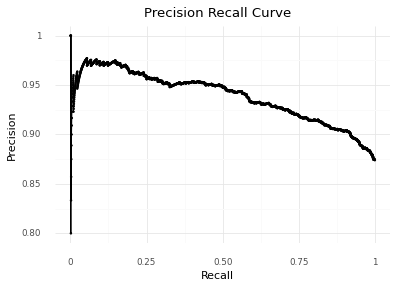

<ggplot: (8787927401189)>

In [4]:
from plotnine import *
import plotnine
plotnine.options.figure_size = (8, 4.8)
(
    ggplot(data = df_recall_precision)+
    geom_point(aes(x = 'Recall',
                   y = 'Precision'),
               size = 0.4)+
    geom_line(aes(x = 'Recall',
                  y = 'Precision'))+
    labs(title = 'Precision Recall Curve')+
    xlab('Recall')+
    ylab('Precision')+
    theme_minimal()
)

In [5]:
fscore = (2 * pre * re) / (pre + re)

In [6]:
index = np.argmax(fscore)
thresholdOpt = round(thr[index], ndigits = 4)
fscoreOpt = round(fscore[index], ndigits = 4)
recallOpt = round(re[index], ndigits = 4)
precisionOpt = round(pre[index], ndigits = 4)
print("neutral")
print('Best Threshold: {} with F-Score: {}'.format(thresholdOpt, fscoreOpt))
print('Recall: {}, Precision: {}'.format(recallOpt, precisionOpt))

neutral
Best Threshold: 0.6205999851226807 with F-Score: 0.9328
Recall: 0.9996, Precision: 0.8744


In [11]:
index = np.argmax(fscore)
thresholdOpt = round(thr[index], ndigits = 4)
fscoreOpt = round(fscore[index], ndigits = 4)
recallOpt = round(re[index], ndigits = 4)
precisionOpt = round(pre[index], ndigits = 4)
print('happy')
print('Best Threshold: {} with F-Score: {}'.format(thresholdOpt, fscoreOpt))
print('Recall: {}, Precision: {}'.format(recallOpt, precisionOpt))

happy
Best Threshold: 0.13850000500679016 with F-Score: 0.3103
Recall: 0.5081, Precision: 0.2233


In [16]:
index = np.argmax(fscore)
thresholdOpt = round(thr[index], ndigits = 4)
fscoreOpt = round(fscore[index], ndigits = 4)
recallOpt = round(re[index], ndigits = 4)
precisionOpt = round(pre[index], ndigits = 4)
print('surprise')
print('Best Threshold: {} with F-Score: {}'.format(thresholdOpt, fscoreOpt))
print('Recall: {}, Precision: {}'.format(recallOpt, precisionOpt))

surprise
Best Threshold: 0.24150000512599945 with F-Score: nan
Recall: 0.0, Precision: 0.0


In [21]:
index = np.argmax(fscore)
thresholdOpt = round(thr[index], ndigits = 4)
fscoreOpt = round(fscore[index], ndigits = 4)
recallOpt = round(re[index], ndigits = 4)
precisionOpt = round(pre[index], ndigits = 4)
print('angry')
print('Best Threshold: {} with F-Score: {}'.format(thresholdOpt, fscoreOpt))
print('Recall: {}, Precision: {}'.format(recallOpt, precisionOpt))

angry
Best Threshold: 0.02590000070631504 with F-Score: nan
Recall: 0.0, Precision: 0.0


In [26]:
index = np.argmax(fscore)
thresholdOpt = round(thr[index], ndigits = 4)
fscoreOpt = round(fscore[index], ndigits = 4)
recallOpt = round(re[index], ndigits = 4)
precisionOpt = round(pre[index], ndigits = 4)
print('disgust')
print('Best Threshold: {} with F-Score: {}'.format(thresholdOpt, fscoreOpt))
print('Recall: {}, Precision: {}'.format(recallOpt, precisionOpt))

disgust
Best Threshold: 0.014299999922513962 with F-Score: nan
Recall: 0.0, Precision: 0.0


In [31]:
index = np.argmax(fscore)
thresholdOpt = round(thr[index], ndigits = 4)
fscoreOpt = round(fscore[index], ndigits = 4)
recallOpt = round(re[index], ndigits = 4)
precisionOpt = round(pre[index], ndigits = 4)
print('sad')
print('Best Threshold: {} with F-Score: {}'.format(thresholdOpt, fscoreOpt))
print('Recall: {}, Precision: {}'.format(recallOpt, precisionOpt))

sad
Best Threshold: 0.0210999995470047 with F-Score: nan
Recall: 0.0, Precision: 0.0


In [36]:
index = np.argmax(fscore)
thresholdOpt = round(thr[index], ndigits = 4)
fscoreOpt = round(fscore[index], ndigits = 4)
recallOpt = round(re[index], ndigits = 4)
precisionOpt = round(pre[index], ndigits = 4)
print('fear')
print('Best Threshold: {} with F-Score: {}'.format(thresholdOpt, fscoreOpt))
print('Recall: {}, Precision: {}'.format(recallOpt, precisionOpt))

fear
Best Threshold: 0.013100000098347664 with F-Score: 0.2712
Recall: 0.2051, Precision: 0.4
